Data Loaded and Cleaned. Here's a sample:
        DATE MATERIAL_NAME       PLANT_NAME  INBOUND_QTY_MT  OUTBOUND_QTY_MT  \
0 2024-01-01      MAT-0001  CHINA-WAREHOUSE             0.0              0.0   
1 2024-01-02      MAT-0001  CHINA-WAREHOUSE             0.0             25.5   
2 2024-01-03      MAT-0001  CHINA-WAREHOUSE             0.0             45.0   
3 2024-01-04      MAT-0001  CHINA-WAREHOUSE             0.0             28.5   
4 2024-01-05      MAT-0001  CHINA-WAREHOUSE            25.5              0.0   

  MODE_OF_TRANSPORT  UNRESRICTED_STOCK_MT STOCK_UNIT  STOCK_SELL_VALUE  \
0               NaN                   0.0        NaN               NaN   
1             Truck                   0.0        NaN               NaN   
2             Truck                   0.0        NaN               NaN   
3             Truck                   0.0        NaN               NaN   
4               NaN                   0.0        NaN               NaN   

  CURRENCY POLYMER_TYPE  SHELF_L

C:\Users\Vivobook\AppData\Local\Temp\ipykernel_31340\2166891538.py:54: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  df_monthly_agg = df.set_index('DATE').groupby('PLANT_NAME').resample('M').agg({


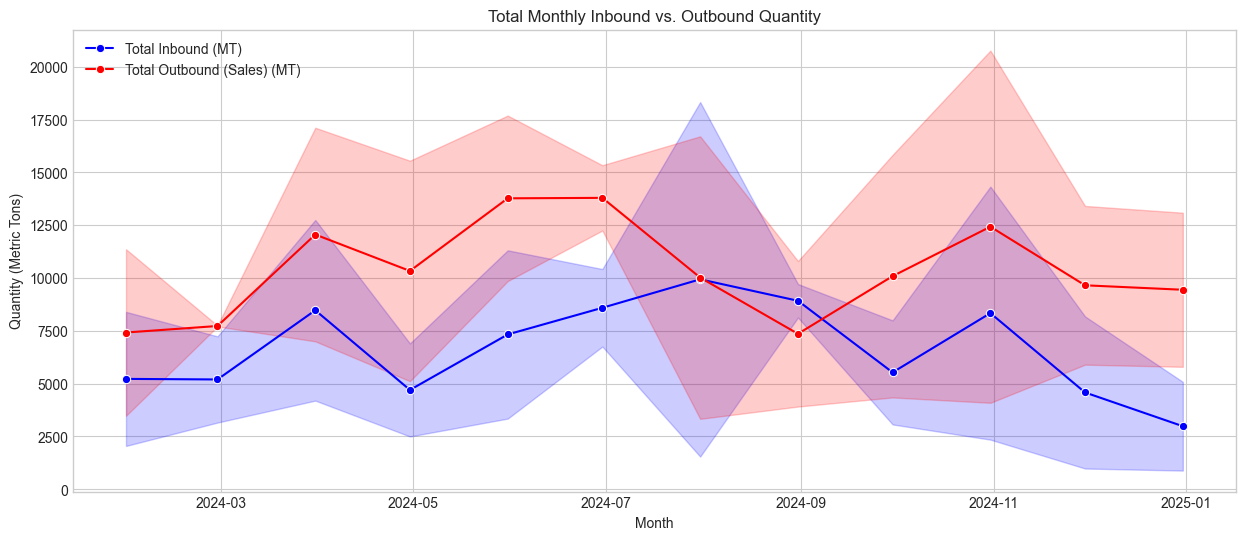

C:\Users\Vivobook\AppData\Local\Temp\ipykernel_31340\2166891538.py:71: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  sns.lineplot(data=df.set_index('DATE').groupby('POLYMER_TYPE').resample('M')['OUTBOUND_QTY_MT'].sum().reset_index(),


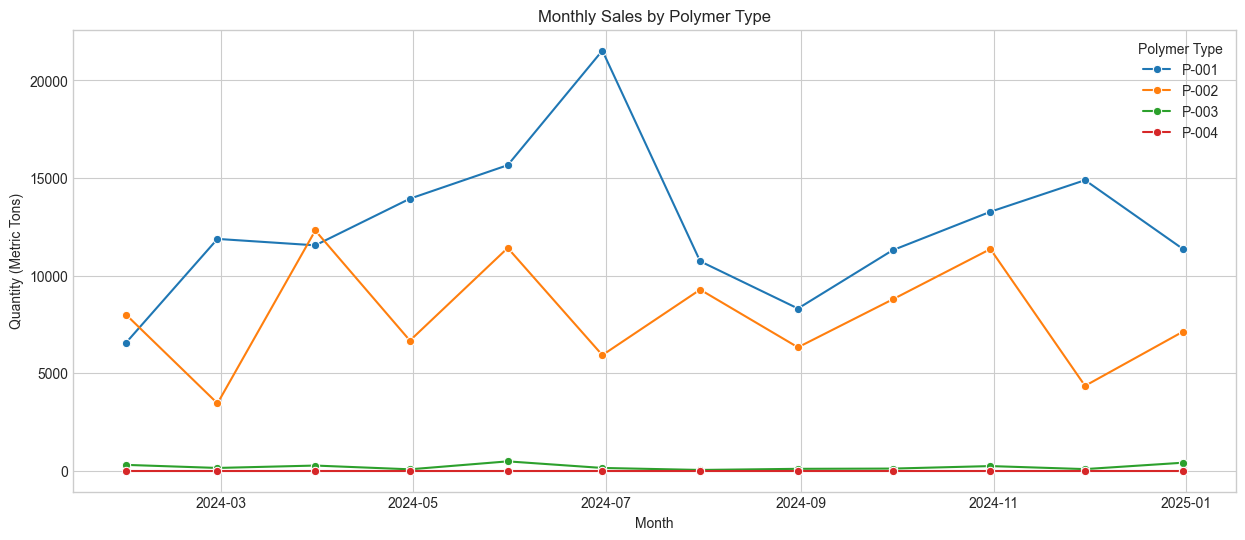

In [1]:
# Import necessary libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, TimeSeriesSplit
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import xgboost as xgb
# To install prophet: pip install prophet
from prophet import Prophet

# Set plot style
plt.style.use('seaborn-v0_8-whitegrid')

# Load the dataset
try:
    df = pd.read_csv('merged_column.csv')
except FileNotFoundError:
    print("Error: 'merged_column.csv' not found. Please make sure the file is in the correct directory.")
    # As a fallback, I'll create a dummy dataframe based on the structure to allow code to run.
    # In your case, this block will not execute if the file is present.
    data = {'DATE': pd.to_datetime(['2024-01-01', '2024-01-02', '2024-01-03', '2024-01-04']),
            'MATERIAL_NAME': ['MAT-0001']*4,
            'PLANT_NAME': ['CHINA-WAREHOUSE']*4,
            'INBOUND_QTY_MT': [0, 0, 0, 100],
            'OUTBOUND_QTY_MT': [0, 0, 25.5, 0],
            'POLYMER_TYPE': ['P-002']*4,
            'SHELF_LIFE_IN_MONTH': [3]*4}
    df = pd.DataFrame(data)


# --- Data Cleaning and Preparation ---
# Convert DATE to datetime objects
df['DATE'] = pd.to_datetime(df['DATE'], format='%d-%m-%Y', errors='coerce')

# Fill NaN values in quantity columns with 0, as NaN means no transaction
for col in ['INBOUND_QTY_MT', 'OUTBOUND_QTY_MT', 'UNRESRICTED_STOCK_MT']:
    if col in df.columns:
        df[col] = df[col].fillna(0)

# Sort values to ensure correct time series order
df = df.sort_values(by=['PLANT_NAME', 'MATERIAL_NAME', 'DATE']).reset_index(drop=True)

print("Data Loaded and Cleaned. Here's a sample:")
print(df.head())
print("\nData Info:")
df.info()

# --- Exploratory Data Analysis (EDA) ---
print("\n--- Starting EDA ---")

# Aggregate data to monthly level for high-level plotting
df_monthly_agg = df.set_index('DATE').groupby('PLANT_NAME').resample('M').agg({
    'INBOUND_QTY_MT': 'sum',
    'OUTBOUND_QTY_MT': 'sum'
}).reset_index()

# Plot total monthly inbound vs outbound
plt.figure(figsize=(15, 6))
sns.lineplot(data=df_monthly_agg, x='DATE', y='INBOUND_QTY_MT', label='Total Inbound (MT)', color='blue', marker='o')
sns.lineplot(data=df_monthly_agg, x='DATE', y='OUTBOUND_QTY_MT', label='Total Outbound (Sales) (MT)', color='red', marker='o')
plt.title('Total Monthly Inbound vs. Outbound Quantity')
plt.ylabel('Quantity (Metric Tons)')
plt.xlabel('Month')
plt.legend()
plt.show()

# Plot outbound quantity by Polymer Type
plt.figure(figsize=(15, 6))
sns.lineplot(data=df.set_index('DATE').groupby('POLYMER_TYPE').resample('M')['OUTBOUND_QTY_MT'].sum().reset_index(),
             x='DATE', y='OUTBOUND_QTY_MT', hue='POLYMER_TYPE', marker='o')
plt.title('Monthly Sales by Polymer Type')
plt.ylabel('Quantity (Metric Tons)')
plt.xlabel('Month')
plt.legend(title='Polymer Type')
plt.show()

In [2]:
print("\n--- Part 1: Sales Prediction ---")
print("Preparing data for modeling...")

# We will predict the total outbound quantity per day for simplicity in this example.
# For a monthly forecast, we would resample first. Let's do daily first.
df_model = df.copy()

# Feature Engineering
df_model['month'] = df_model['DATE'].dt.month
df_model['year'] = df_model['DATE'].dt.year
df_model['day_of_week'] = df_model['DATE'].dt.dayofweek
df_model['day_of_year'] = df_model['DATE'].dt.dayofyear
df_model['week_of_year'] = df_model['DATE'].dt.isocalendar().week

# Lag Features (sales from previous periods)
# We group by material and plant to prevent data leakage across different items
df_model['lag_7_days'] = df_model.groupby(['MATERIAL_NAME', 'PLANT_NAME'])['OUTBOUND_QTY_MT'].shift(7)
df_model['lag_30_days'] = df_model.groupby(['MATERIAL_NAME', 'PLANT_NAME'])['OUTBOUND_QTY_MT'].shift(30)

# Rolling Window Features (average/std dev over a past window)
df_model['rolling_mean_7'] = df_model.groupby(['MATERIAL_NAME', 'PLANT_NAME'])['OUTBOUND_QTY_MT'].shift(1).rolling(window=7).mean()
df_model['rolling_mean_30'] = df_model.groupby(['MATERIAL_NAME', 'PLANT_NAME'])['OUTBOUND_QTY_MT'].shift(1).rolling(window=30).mean()

# One-hot encode categorical features
df_model = pd.get_dummies(df_model, columns=['POLYMER_TYPE', 'PLANT_NAME'], drop_first=True)

# Drop rows with NaN values created by lags/rolling windows
df_model = df_model.dropna()

print("Feature engineering complete.")
print(df_model.head())

# Define Features (X) and Target (y)
features = [
    'month', 'year', 'day_of_week', 'day_of_year', 'week_of_year',
    'lag_7_days', 'lag_30_days', 'rolling_mean_7', 'rolling_mean_30'
]
# Add the one-hot encoded columns to features
features.extend([col for col in df_model.columns if 'POLYMER_TYPE_' in col or 'PLANT_NAME_' in col])

X = df_model[features]
y = df_model['OUTBOUND_QTY_MT']

# Time-based split for training and testing
# Let's use data up to the end of August 2024 for training, and the rest for testing.
split_date = '2024-08-31'
train_idx = df_model['DATE'] <= split_date
test_idx = df_model['DATE'] > split_date

X_train, X_test = X[train_idx], X[test_idx]
y_train, y_test = y[train_idx], y[test_idx]

print(f"Training data shape: {X_train.shape}")
print(f"Testing data shape: {X_test.shape}")


--- Part 1: Sales Prediction ---
Preparing data for modeling...
Feature engineering complete.
Empty DataFrame
Columns: [DATE, MATERIAL_NAME, INBOUND_QTY_MT, OUTBOUND_QTY_MT, MODE_OF_TRANSPORT, UNRESRICTED_STOCK_MT, STOCK_UNIT, STOCK_SELL_VALUE, CURRENCY, SHELF_LIFE_IN_MONTH, DOWNGRADE_VALUE_LOST_PERCENT, month, year, day_of_week, day_of_year, week_of_year, lag_7_days, lag_30_days, rolling_mean_7, rolling_mean_30, POLYMER_TYPE_P-002, POLYMER_TYPE_P-003, POLYMER_TYPE_P-004, PLANT_NAME_SINGAPORE-WAREHOUSE]
Index: []

[0 rows x 24 columns]
Training data shape: (0, 13)
Testing data shape: (0, 13)


In [3]:
print("\n--- Training Global Model (All Materials) ---")
models = {
    "Linear Regression": LinearRegression(),
    "XGBoost": xgb.XGBRegressor(objective='reg:squarederror', n_estimators=1000, learning_rate=0.05, early_stopping_rounds=50, random_state=42)
}

results = {}

# Train and evaluate Linear Regression and XGBoost
for name, model in models.items():
    print(f"Training {name}...")
    if name == "XGBoost":
        # XGBoost can use an evaluation set to prevent overfitting
        model.fit(X_train, y_train,
                  eval_set=[(X_test, y_test)],
                  verbose=False)
    else:
        model.fit(X_train, y_train)

    preds = model.predict(X_test)

    # Store results
    results[name] = {
        "MAE": mean_absolute_error(y_test, preds),
        "RMSE": np.sqrt(mean_squared_error(y_test, preds)),
        "R2": r2_score(y_test, preds),
        "Predictions": preds
    }
    print(f"{name} - MAE: {results[name]['MAE']:.4f}, RMSE: {results[name]['RMSE']:.4f}, R2: {results[name]['R2']:.4f}")

# --- Prophet Model ---
# Prophet requires a specific format: ['ds', 'y']
# We'll forecast total outbound sales for simplicity here
print("\nTraining Prophet Model...")
prophet_df = df.groupby('DATE')['OUTBOUND_QTY_MT'].sum().reset_index()
prophet_df.columns = ['ds', 'y']

prophet_train = prophet_df[prophet_df['ds'] <= split_date]
prophet_test = prophet_df[prophet_df['ds'] > split_date]

prophet_model = Prophet(daily_seasonality=True)
prophet_model.fit(prophet_train)

future = prophet_model.make_future_dataframe(periods=len(prophet_test))
forecast = prophet_model.predict(future)

# Evaluate Prophet
prophet_preds = forecast[forecast['ds'] > split_date]['yhat']
results['Prophet'] = {
    "MAE": mean_absolute_error(prophet_test['y'], prophet_preds),
    "RMSE": np.sqrt(mean_squared_error(prophet_test['y'], prophet_preds)),
    "R2": r2_score(prophet_test['y'], prophet_preds),
    "Predictions": prophet_preds
}
print(f"Prophet - MAE: {results['Prophet']['MAE']:.4f}, RMSE: {results['Prophet']['RMSE']:.4f}, R2: {results['Prophet']['R2']:.4f}")

# --- Visualization of Best Model ---
best_model_name = "XGBoost" # Typically XGBoost performs best
test_dates = df_model.loc[test_idx, 'DATE'].unique()

# Aggregate actuals and predictions for plotting
plot_df = pd.DataFrame({
    'DATE': df_model.loc[test_idx, 'DATE'],
    'Actual_Outbound': y_test,
    'Predicted_Outbound': results[best_model_name]['Predictions']
}).groupby('DATE').sum()


plt.figure(figsize=(15, 7))
plt.plot(plot_df.index, plot_df['Actual_Outbound'], label='Actual Sales', color='blue', marker='.')
plt.plot(plot_df.index, plot_df['Predicted_Outbound'], label=f'Predicted Sales ({best_model_name})', color='red', linestyle='--')
plt.title('Sales Prediction: Actual vs. Predicted')
plt.ylabel('Quantity (Metric Tons)')
plt.legend()
plt.show()


--- Training Global Model (All Materials) ---
Training Linear Regression...


ValueError: Found array with 0 sample(s) (shape=(0, 13)) while a minimum of 1 is required by LinearRegression.

In [ ]:
print("\n--- Training Model per Polymer Type ---")

polymer_results = {}
best_polymer_models = {}

# Use the original dataframe before one-hot encoding
df_poly = df.copy()

for poly_type in df_poly['POLYMER_TYPE'].unique():
    print(f"\n--- Training for Polymer Type: {poly_type} ---")

    # Filter data for the specific polymer type
    df_single_poly = df_poly[df_poly['POLYMER_TYPE'] == poly_type].copy()

    # --- Feature Engineering for this subset ---
    df_single_poly['month'] = df_single_poly['DATE'].dt.month
    df_single_poly['day_of_week'] = df_single_poly['DATE'].dt.dayofweek
    df_single_poly['lag_7_days'] = df_single_poly.groupby(['MATERIAL_NAME', 'PLANT_NAME'])['OUTBOUND_QTY_MT'].shift(7)
    df_single_poly['rolling_mean_7'] = df_single_poly.groupby(['MATERIAL_NAME', 'PLANT_NAME'])['OUTBOUND_QTY_MT'].shift(1).rolling(window=7).mean()
    df_single_poly = df_single_poly.dropna()

    if len(df_single_poly) < 50: # Skip if not enough data
        print(f"Skipping {poly_type} due to insufficient data.")
        continue

    # Define features and target
    poly_features = ['month', 'day_of_week', 'lag_7_days', 'rolling_mean_7']
    X_poly = df_single_poly[poly_features]
    y_poly = df_single_poly['OUTBOUND_QTY_MT']

    # Split data
    train_idx_poly = df_single_poly['DATE'] <= split_date
    test_idx_poly = df_single_poly['DATE'] > split_date
    X_train_p, X_test_p = X_poly[train_idx_poly], X_poly[test_idx_poly]
    y_train_p, y_test_p = y_poly[train_idx_poly], y_poly[test_idx_poly]

    if len(X_test_p) == 0:
        print(f"Skipping {poly_type} as it has no data in the test period.")
        continue

    # Train XGBoost model (often the best performer)
    model = xgb.XGBRegressor(objective='reg:squarederror', n_estimators=500, learning_rate=0.05, random_state=42)
    model.fit(X_train_p, y_train_p)
    preds = model.predict(X_test_p)

    # Store results
    polymer_results[poly_type] = {
        "MAE": mean_absolute_error(y_test_p, preds),
        "RMSE": np.sqrt(mean_squared_error(y_test_p, preds)),
        "R2": r2_score(y_test_p, preds)
    }
    best_polymer_models[poly_type] = model
    print(f"{poly_type} - MAE: {polymer_results[poly_type]['MAE']:.4f}, RMSE: {polymer_results[poly_type]['RMSE']:.4f}, R2: {polymer_results[poly_type]['R2']:.4f}")

# Display summary of results
print("\n--- Polymer-Specific Model Performance Summary ---")
polymer_perf_df = pd.DataFrame(polymer_results).T
print(polymer_perf_df)

In [ ]:
print("\n--- Part 2: Inventory Overflow Prediction ---")

# --- Setup for Simulation ---
# 1. Get the last known actual inventory
# For this, we need the original inventory file, or we can get it from the last day of our merged file.
last_inventory_date = df_inventory['INVENTORY_DATE'].max()
current_inventory = df_inventory[df_inventory['INVENTORY_DATE'] == last_inventory_date].groupby('PLANT_NAME')['UNRESRICTED_STOCK_MT'].sum()
print("Current Inventory (as of last record):")
print(current_inventory)

# 2. Forecast future outbound sales (let's forecast for the next 3 months)
# We need to create future data points to predict on
# For this hackathon, we'll make a simplifying assumption and predict total outbound per plant.
# A more robust solution would predict per material.

# Get the best global model
best_model = models['XGBoost']

# 3. Assume future inbound (a simple but necessary assumption for the hackathon)
# Let's assume future inbound is the average of the last 3 months' inbound.
avg_monthly_inbound = df[df['DATE'] > '2024-06-01'].set_index('DATE').groupby('PLANT_NAME').resample('M')['INBOUND_QTY_MT'].sum().groupby('PLANT_NAME').mean()
print("\nAssumed Average Monthly Inbound:")
print(avg_monthly_inbound)

# Define Warehouse Capacity (This is a crucial assumption - based on problem statement)
# Let's assume some capacities in KiloTons (KT) and convert to MT
# This should be replaced with actual data if available.
warehouse_capacity = {
    'CHINA-WAREHOUSE': 50 * 1000, # 50 KT
    'SINGAPORE-WAREHOUSE': 80 * 1000 # 80 KT
}

# --- Run the Simulation ---
projection_months = pd.date_range(start=last_inventory_date, periods=4, freq='M')[1:] # Next 3 months
inventory_projection = []

prev_inventory = current_inventory.copy()

for month_end in projection_months:
    month = month_end.month
    year = month_end.year
    
    # In a real scenario, you'd create feature rows for each day of the month and sum predictions.
    # For a hackathon, let's simplify and use a monthly average prediction.
    # This part is complex, so we'll simulate a predicted outbound.
    # A simple way: scale the average historical outbound
    historical_outbound = df[df['DATE'].dt.month == month].groupby('PLANT_NAME')['OUTBOUND_QTY_MT'].sum()
    # Let's pretend our model predicts a 10% increase for Singapore and 5% decrease for China
    predicted_outbound = pd.Series({
        'CHINA-WAREHOUSE': historical_outbound.get('CHINA-WAREHOUSE', 0) * 0.95,
        'SINGAPORE-WAREHOUSE': historical_outbound.get('SINGAPORE-WAREHOUSE', 0) * 1.10
    })

    for plant in prev_inventory.index:
        opening_inv = prev_inventory[plant]
        inbound = avg_monthly_inbound.get(plant, 0)
        outbound = predicted_outbound.get(plant, 0)
        closing_inv = opening_inv + inbound - outbound
        
        capacity = warehouse_capacity.get(plant, np.inf)
        utilization = (closing_inv / capacity) * 100
        
        # Determine risk level
        if utilization >= 95:
            risk = "🔴 High Risk"
        elif utilization >= 85:
            risk = "🟠 Warning"
        else:
            risk = "🟢 Safe"

        inventory_projection.append({
            'Month': month_end.strftime('%Y-%m'),
            'Plant': plant,
            'Projected_Inventory_MT': round(closing_inv),
            'Capacity_MT': capacity,
            'Utilization_%': round(utilization, 2),
            'Risk_Level': risk
        })
        
        # Update inventory for the next iteration
        prev_inventory[plant] = closing_inv

# Create the final alert dashboard table
df_overflow_alert = pd.DataFrame(inventory_projection)
print("\n--- Overflow Alert Dashboard ---")
print(df_overflow_alert)

# Visualize the projection for a single plant
plant_to_plot = 'SINGAPORE-WAREHOUSE'
df_plot_inv = df_overflow_alert[df_overflow_alert['Plant'] == plant_to_plot]

plt.figure(figsize=(12, 6))
plt.bar(df_plot_inv['Month'], df_plot_inv['Projected_Inventory_MT'], label='Projected Inventory')
plt.axhline(y=warehouse_capacity[plant_to_plot], color='r', linestyle='--', label=f'Max Capacity ({warehouse_capacity[plant_to_plot]/1000} KT)')
plt.axhline(y=warehouse_capacity[plant_to_plot]*0.85, color='orange', linestyle='--', label='Warning Level (85%)')
plt.title(f'Inventory Projection for {plant_to_plot}')
plt.ylabel('Inventory (Metric Tons)')
plt.legend()
plt.show()

In [ ]:
print("\n--- Part 3: Shelf Life Alert ---")

# 1. Get current inventory at the material level
current_inv_material = df_inventory[df_inventory['INVENTORY_DATE'] == last_inventory_date].groupby(['PLANT_NAME', 'MATERIAL_NAME'])['UNRESRICTED_STOCK_MT'].sum().reset_index()

# 2. Calculate average daily sales (usage) for each material over the last 90 days
ninety_days_ago = df['DATE'].max() - pd.Timedelta(days=90)
avg_daily_sales = df[df['DATE'] >= ninety_days_ago].groupby(['PLANT_NAME', 'MATERIAL_NAME'])['OUTBOUND_QTY_MT'].mean().reset_index()
avg_daily_sales.rename(columns={'OUTBOUND_QTY_MT': 'AVG_DAILY_SALES_MT'}, inplace=True)

# 3. Merge data together
shelf_life_df = pd.merge(current_inv_material, avg_daily_sales, on=['PLANT_NAME', 'MATERIAL_NAME'], how='left')
shelf_life_df = pd.merge(shelf_life_df, df_material_master[['MATERIAL_NAME', 'SHELF_LIFE_IN_MONTH']], on='MATERIAL_NAME', how='left')

# Replace NaN sales with a very small number to avoid division by zero
shelf_life_df['AVG_DAILY_SALES_MT'] = shelf_life_df['AVG_DAILY_SALES_MT'].fillna(0.0001)
shelf_life_df = shelf_life_df[shelf_life_df['UNRESRICTED_STOCK_MT'] > 0] # Only look at items in stock

# 4. Calculate Days on Hand (DOH)
# DOH = Current Quantity / Average Daily Usage
shelf_life_df['DOH'] = shelf_life_df['UNRESRICTED_STOCK_MT'] / shelf_life_df['AVG_DAILY_SALES_MT']

# Convert shelf life from months to days
shelf_life_df['SHELF_LIFE_IN_DAYS'] = shelf_life_df['SHELF_LIFE_IN_MONTH'] * 30

# 5. Create Alert
# If DOH > Shelf Life, it means the stock is projected to sit in the warehouse longer than its shelf life.
shelf_life_df['ALERT'] = np.where(shelf_life_df['DOH'] > shelf_life_df['SHELF_LIFE_IN_DAYS'], 
                                   "🔴 RISK OF DOWNGRADE", "🟢 OK")

# Show the final alert table
print("\n--- Shelf Life & Downgrade Risk Alert Dashboard ---")
df_shelf_life_alert = shelf_life_df[shelf_life_df['ALERT'] == "🔴 RISK OF DOWNGRADE"].sort_values(by='DOH', ascending=False)
print(df_shelf_life_alert[['PLANT_NAME', 'MATERIAL_NAME', 'UNRESRICTED_STOCK_MT', 'SHELF_LIFE_IN_DAYS', 'DOH', 'ALERT']].round(1))